In [1]:
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from matplotlib import colormaps


from tqdm.auto import tqdm
from fsrs_optimizer import (
    lineToTensor,
    next_interval,
    power_forgetting_curve,
    FSRS,
    DEFAULT_PARAMETER,
)

plt.style.use("ggplot")
cmap = colormaps.get_cmap("tab10")

desired_retention = 0.8
deck_size = 20000
learn_span = 1000

learn_limit_perday = 20
review_limit_perday = 80

first_rating_prob = np.array([0.24, 0.094, 0.495, 0.171])
review_rating_prob = np.array([0.224, 0.631, 0.145])
review_costs = np.array([23.0, 11.68, 7.33, 5.6])
learn_costs = np.array([33.79, 24.3, 13.68, 6.5])

seed = 42
moving_average_win_size = 30

  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: due_date_asc
learned cards: 20000
time in minutes: 24352.6
remembered cards: 14349
time per remembered card: 1.7



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: interval_asc
learned cards: 20000
time in minutes: 20212.0
remembered cards: 13136
time per remembered card: 1.54



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: interval_desc
learned cards: 20000
time in minutes: 20938.4
remembered cards: 11792
time per remembered card: 1.78



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: difficulty_asc
learned cards: 20000
time in minutes: 20322.4
remembered cards: 14624
time per remembered card: 1.39



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: difficulty_desc
learned cards: 20000
time in minutes: 20326.6
remembered cards: 11405
time per remembered card: 1.78



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: retrievability_asc
learned cards: 20000
time in minutes: 22832.8
remembered cards: 14590
time per remembered card: 1.56



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: retrievability_desc
learned cards: 20000
time in minutes: 20206.2
remembered cards: 13979
time per remembered card: 1.45



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: stability_asc
learned cards: 20000
time in minutes: 20269.6
remembered cards: 13097
time per remembered card: 1.55



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: stability_desc
learned cards: 20000
time in minutes: 20358.1
remembered cards: 13779
time per remembered card: 1.48



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: random
learned cards: 20000
time in minutes: 23490.5
remembered cards: 14237
time per remembered card: 1.65



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: add_order_asc
learned cards: 20000
time in minutes: 21071.0
remembered cards: 11749
time per remembered card: 1.79



  0%|          | 0/1000 [00:00<?, ?it/s]

review sorting order: add_order_desc
learned cards: 20000
time in minutes: 20244.7
remembered cards: 13504
time per remembered card: 1.5



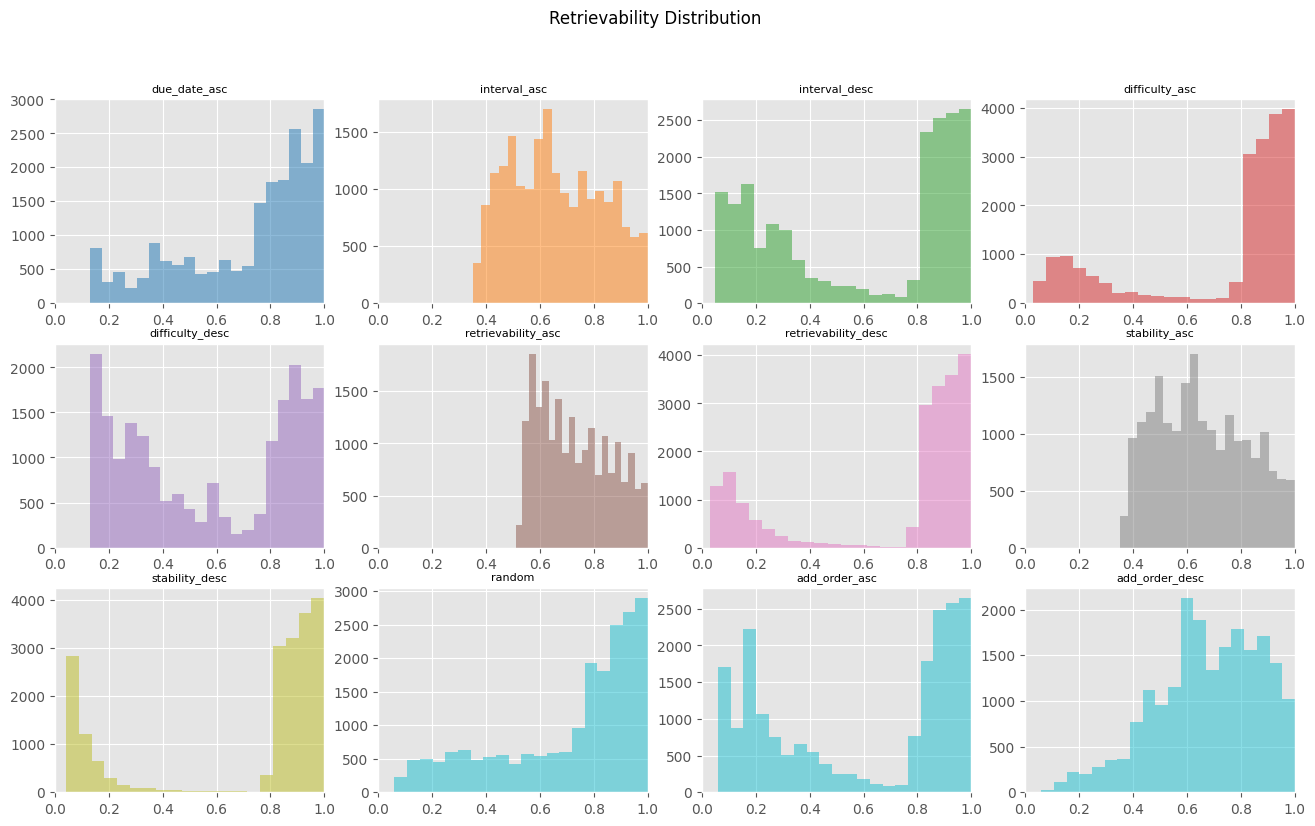

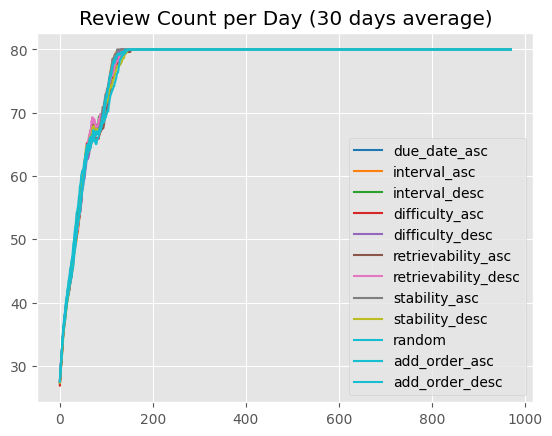

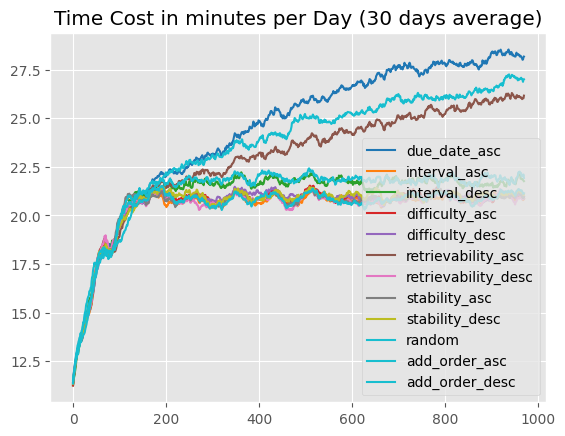

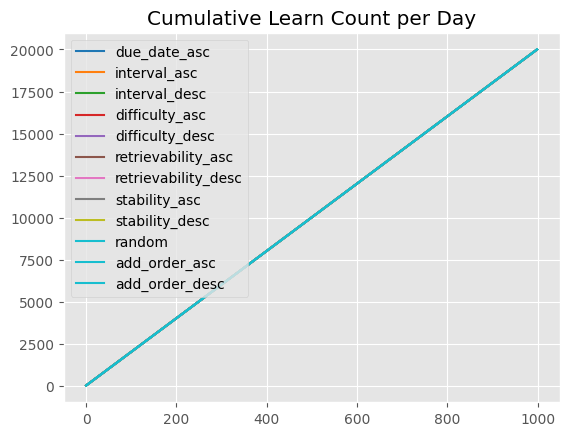

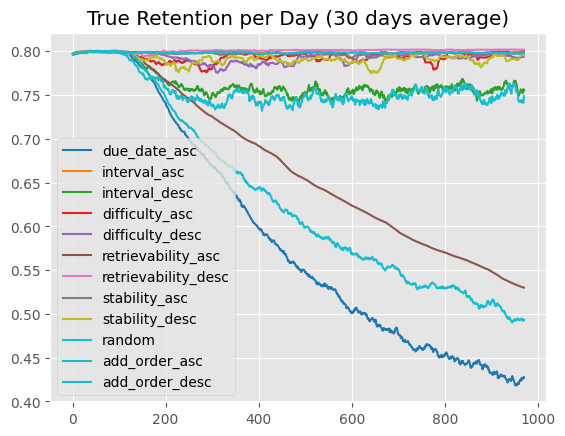

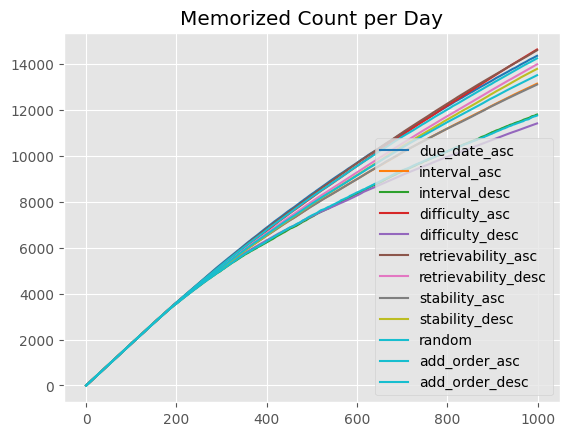

In [2]:
feature_list = [
    "difficulty",
    "stability",
    "retrievability",
    "interval",
    "delta_t",
    "reps",
    "lapses",
    "last_date",
    "due",
    "r_history",
    "t_history",
    "p_history",
    "states",
    "time",
]
field_map = {key: i for i, key in enumerate(feature_list)}


def generate_rating(review_type):
    if review_type == "new":
        return np.random.choice([1, 2, 3, 4], p=first_rating_prob)
    elif review_type == "recall":
        return np.random.choice([2, 3, 4], p=review_rating_prob)


class Collection:
    def __init__(self):
        self.model = FSRS(DEFAULT_PARAMETER)
        self.model.eval()

    def states(self, t_history, r_history):
        with torch.no_grad():
            line_tensor = lineToTensor(
                list(zip([str(t_history)], [str(r_history)]))[0]
            ).unsqueeze(1)
            output_t = self.model(line_tensor)
            return output_t[-1][0]

    def next_states(self, states, t, r):
        with torch.no_grad():
            return self.model.step(torch.FloatTensor([[t, r]]), states.unsqueeze(0))[0]

    def init(self):
        t = 0
        r = generate_rating("new")
        p = round(first_rating_prob[r - 1], 2)
        new_states = self.states(t, r)
        return r, t, p, new_states


def moving_average(data, window_size=moving_average_win_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode="valid")


review_sorting_orders = [
    "due_date_asc",
    "interval_asc",
    "interval_desc",
    "difficulty_asc",
    "difficulty_desc",
    "retrievability_asc",
    "retrievability_desc",
    "stability_asc",
    "stability_desc",
    "random",
    "add_order_asc",
    "add_order_desc",
]

fig = plt.figure(0, figsize=(16, 9))
fig.suptitle("Retrievability Distribution")
axes = fig.subplots(3, 4)
axes = axes.flatten()

for i, review_sorting_order in enumerate(review_sorting_orders):
    new_card_per_day = np.array([0] * learn_span)
    review_card_per_day = np.array([0.0] * learn_span)
    time_per_day = np.array([0.0] * learn_span)
    learned_per_day = np.array([0.0] * learn_span)
    retention_per_day = np.array([0.0] * learn_span)
    expected_memorization_per_day = np.array([0.0] * learn_span)


    card = pd.DataFrame(
        np.zeros((deck_size, len(feature_list))),
        index=range(deck_size),
        columns=feature_list,
    )
    card["states"] = card["states"].astype(object)
    card["r_history"] = card["r_history"].astype(str)
    card["t_history"] = card["t_history"].astype(str)
    card["p_history"] = card["p_history"].astype(str)
    card["reps"] = 0
    card["lapses"] = 0
    card["due"] = learn_span

    student = Collection()

    np.random.seed(seed)
    random.seed(seed)
    for day in tqdm(range(learn_span)):
        reviewed = 0
        learned = 0
        review_time_today = 0
        learn_time_today = 0

        card["delta_t"] = day - card["last_date"]
        card["retrievability"] = power_forgetting_curve(
            card["delta_t"], card["stability"]
        )
        need_review = card[card["due"] <= day]

        sum_true_retrievability_today = 0

        if review_sorting_order == "due_date_asc":
            need_review = need_review.sort_values("due", ascending=True)
        elif review_sorting_order == "interval_asc":
            need_review = need_review.sort_values("interval", ascending=True)
        elif review_sorting_order == "interval_desc":
            need_review = need_review.sort_values("interval", ascending=False)
        elif review_sorting_order == "difficulty_asc":
            need_review = need_review.sort_values("difficulty", ascending=True)
        elif review_sorting_order == "difficulty_desc":
            need_review = need_review.sort_values(
                "difficulty", ascending=False)
        elif review_sorting_order == "retrievability_asc":
            need_review = need_review.sort_values(
                "retrievability", ascending=True)
        elif review_sorting_order == "retrievability_desc":
            need_review = need_review.sort_values(
                "retrievability", ascending=False)
        elif review_sorting_order == "stability_asc":
            need_review = need_review.sort_values("stability", ascending=True)
        elif review_sorting_order == "stability_desc":
            need_review = need_review.sort_values("stability", ascending=False)
        elif review_sorting_order == "random":
            need_review = need_review.sample(frac=1)
        elif review_sorting_order == "add_order_asc":
            need_review = need_review.sort_index(ascending=True)
        elif review_sorting_order == "add_order_desc":
            need_review = need_review.sort_index(ascending=False)

        for idx in need_review.index:
            if reviewed >= review_limit_perday:
                break

            reviewed += 1
            last_date = card.iat[idx, field_map["last_date"]]
            due = card.iat[idx, field_map["due"]]
            card.iat[idx, field_map["last_date"]] = day
            ivl = card.iat[idx, field_map["delta_t"]]
            card.iat[idx, field_map["t_history"]] += f",{ivl}"
            stability = card.iat[idx, field_map["stability"]]
            retrievability = card.iat[idx, field_map["retrievability"]]
            sum_true_retrievability_today += retrievability
            card.iat[idx, field_map["p_history"]] += f",{retrievability:.2f}"
            reps = card.iat[idx, field_map["reps"]]
            lapses = card.iat[idx, field_map["lapses"]]
            states = card.iat[idx, field_map["states"]]

            if random.random() < retrievability:
                rating = generate_rating("recall")
                recall_time = review_costs[rating - 1]
                review_time_today += recall_time
                card.iat[idx, field_map["r_history"]] += f",{rating}"
                new_states = student.next_states(states, ivl, rating)
                new_stability = float(new_states[0])
                new_difficulty = float(new_states[1])
                card.iat[idx, field_map["stability"]] = new_stability
                card.iat[idx, field_map["difficulty"]] = new_difficulty
                card.iat[idx, field_map["states"]] = new_states
                card.iat[idx, field_map["reps"]] = reps + 1
                card.iat[idx, field_map["time"]] += recall_time
                interval = next_interval(new_stability, desired_retention)
                card.iat[idx, field_map["interval"]] = interval
                card.iat[idx, field_map["due"]] = day + interval
            else:
                review_time_today += review_costs[0]

                rating = 1
                card.iat[idx, field_map["r_history"]] += f",{rating}"

                new_states = student.next_states(states, ivl, 1)
                new_stability = float(new_states[0])
                new_difficulty = float(new_states[1])

                card.iat[idx, field_map["stability"]] = new_stability
                card.iat[idx, field_map["difficulty"]] = new_difficulty
                card.iat[idx, field_map["states"]] = new_states

                reps = 0
                lapses = lapses + 1

                card.iat[idx, field_map["reps"]] = reps
                card.iat[idx, field_map["lapses"]] = lapses

                interval = next_interval(new_stability, desired_retention)
                card.iat[idx, field_map["interval"]] = interval
                card.iat[idx, field_map["due"]] = day + interval
                card.iat[idx, field_map["time"]] += review_costs[0]

        retention_per_day[day] = (
            sum_true_retrievability_today / reviewed if reviewed > 0 else np.nan
        )

        need_learn = card[card["stability"] == 0]

        for idx in need_learn.index:
            if learned >= learn_limit_perday:
                break
            learned += 1
            r, t, p, new_states = student.init()
            learn_time_today += learn_costs[r - 1]
            card.iat[idx, field_map["last_date"]] = day

            card.iat[idx, field_map["reps"]] = 1
            card.iat[idx, field_map["lapses"]] = 0

            new_stability = float(new_states[0])
            new_difficulty = float(new_states[1])

            card.iat[idx, field_map["r_history"]] = str(r)
            card.iat[idx, field_map["t_history"]] = str(t)
            card.iat[idx, field_map["p_history"]] = str(p)
            card.iat[idx, field_map["stability"]] = new_stability
            card.iat[idx, field_map["difficulty"]] = new_difficulty
            card.iat[idx, field_map["states"]] = new_states

            delta_t = next_interval(new_stability, desired_retention)
            card.iat[idx, field_map["due"]] = day + delta_t
            card.iat[idx, field_map["time"]] = learn_costs[r - 1]

        new_card_per_day[day] = learned
        review_card_per_day[day] = reviewed
        learned_per_day[day] = learned_per_day[day - 1] + learned
        time_per_day[day] = review_time_today + learn_time_today
        expected_memorization_per_day[day] = sum(
            card[card["retrievability"] > 0]["retrievability"]
        )

    total_learned = sum(new_card_per_day)
    total_time = sum(time_per_day)
    total_remembered = int(card["retrievability"].sum())

    plt.figure(1)
    plt.plot(
        moving_average(review_card_per_day),
        label=f"{review_sorting_order}",
        color=cmap(i),
    )
    plt.figure(2)
    plt.plot(
        moving_average(time_per_day) / 60,
        label=f"{review_sorting_order}",
        color=cmap(i),
    )
    plt.figure(3)
    plt.plot(learned_per_day, label=f"{review_sorting_order}", color=cmap(i))
    plt.figure(4)
    plt.plot(
        moving_average(retention_per_day),
        label=f"{review_sorting_order}",
        color=cmap(i),
    )
    plt.figure(5)
    plt.plot(
        expected_memorization_per_day, label=f"{review_sorting_order}", color=cmap(i)
    )

    print("review sorting order:", review_sorting_order)
    print("learned cards:", total_learned)
    print("time in minutes:", round(total_time / 60, 1))
    print("remembered cards:", total_remembered)
    print("time per remembered card:", round(
        total_time / 60 / total_remembered, 2))
    print()

    save = card[card["retrievability"] > 0].copy()
    save["stability"] = round(save["stability"], 2)
    save["retrievability"] = round(save["retrievability"], 2)
    save["difficulty"] = round(save["difficulty"], 2)
    save["time"] = round(save["time"], 2)

    save.to_csv(
        f"./simulator-{review_sorting_order}.tsv", index=False, sep="\t")

    axes[i].hist(
        save["retrievability"],
        bins=20,
        alpha=0.5,
        color=cmap(i),
    )
    axes[i].set_xlim(0, 1)
    axes[i].set_title(f"{review_sorting_order}", fontsize=8)

fig.show()

plt.figure(1)
plt.title(f"Review Count per Day ({moving_average_win_size} days average)")
plt.legend()
plt.figure(2)
plt.title(
    f"Time Cost in minutes per Day ({moving_average_win_size} days average)")
plt.legend()
plt.figure(3)
plt.title("Cumulative Learn Count per Day")
plt.legend()
plt.figure(4)
plt.title(f"True Retention per Day ({moving_average_win_size} days average)")
plt.legend()
plt.figure(5)
plt.title("Memorized Count per Day")
plt.legend()
plt.show()
plt.close("all")